Import package + model

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis
from tqdm import tqdm

In [16]:
M_xanthus = read_sbml_model(
    "../M_xanthus_model.sbml"
)  # import the Myxococcus xanthus model
M_xanthus

Name,myxo_model
Memory address,7c0a16b12c10
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [17]:
type(M_xanthus)

cobra.core.model.Model

In [18]:
E_coli = read_sbml_model("../E_coli_model.sbml")
E_coli

Name,iML1515
Memory address,7c0a16c3e8b0
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


**Adding Reactions**

In [19]:
Biomass_e = cobra.Metabolite(
    "Biomass_e", formula="BIOMASS", name="Biomass [e]", compartment="e"
)

M_xanthus.add_metabolites(Biomass_e)  # add M_xanthus.metabolites.Biomass_e

M_xanthus.add_boundary(
    M_xanthus.metabolites.get_by_id("Biomass_e"), type="exchange"
)  # add the exchange reaction for Biomass_e

Reaction identifier,EX_Biomass_e
Name,Biomass [e] exchange
Memory address,0x7c0a07d79860
Stoichiometry,Biomass_e <=> Biomass [e] <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [20]:
Mreaction = cobra.Reaction("PR_BIOMASS")
Mreaction.name = "Predation Biomass"
Mreaction.subsystem = ""
Mreaction.lower_bound = 0.0  # This is the default
Mreaction.upper_bound = 1000.0  # This is the default

Biomass_e = M_xanthus.metabolites.Biomass_e

spmd_e = (
    M_xanthus.metabolites.spmd_e
)  # carbon source from exchange used in biomass reaction
pheme_e = M_xanthus.metabolites.pheme_e
val_L_e = M_xanthus.metabolites.val_L_e  # imported AA
ile_L_e = M_xanthus.metabolites.ile_L_e
leu_L_e = M_xanthus.metabolites.leu_L_e
lys_L_e = M_xanthus.metabolites.lys_L_e
his_L_e = M_xanthus.metabolites.his_L_e
gly_cys_L_e = M_xanthus.metabolites.gly_cys_L_e
cgly_e = M_xanthus.metabolites.cgly_e
pro_L_e = M_xanthus.metabolites.pro_L_e
alaala_e = M_xanthus.metabolites.alaala_e
glu_L_c = M_xanthus.metabolites.glu_L_c
met_L_e = M_xanthus.metabolites.met_L_e
thr_L_e = M_xanthus.metabolites.thr_L_e
fru_e = M_xanthus.metabolites.fru_e  # import fructose
man_e = M_xanthus.metabolites.man_e
# malt_e = M_xanthus.metabolites.malt_e
acald_e = M_xanthus.metabolites.acald_e  # import FA
acac_e = M_xanthus.metabolites.acac_e
# glyc3p_e = M_xanthus.metabolites.glyc3p_e
# gam_e = M_xanthus.metabolites.gam_e
fum_e = M_xanthus.metabolites.fum_e # should put directly the amino acids? asp and arg?
orn_e = M_xanthus.metabolites.orn_e
# succ_e = M_xanthus.metabolites.succ_e
pi_e = M_xanthus.metabolites.pi_e # from research

Mreaction.add_metabolites(
    {
        Biomass_e: -1,
        spmd_e: 1,
        pheme_e: 1,
        val_L_e: 1,
        ile_L_e: 1,
        leu_L_e: 1,
        lys_L_e: 1,
        his_L_e: 1,
        gly_cys_L_e: 1,
        cgly_e: 1,
        pro_L_e: 1,
        alaala_e: 1,
        fru_e: 1,
        man_e: 1,
        # Smalt_e: 1,
        glu_L_c: 1,
        met_L_e: 1,
        thr_L_e: 1,
        # gam_e: 1,
        fum_e: 1,
        orn_e: 1,
        # succ_e: 1,
        acald_e: 1,
        acac_e: 1,
        # glyc3p_e: 1,
        pi_e: 1
    }
)  # add the metabolites to the reaction

Mreaction.gene_reaction_rule = ""  # define which gene allow the reaction

M_xanthus.add_reactions([Mreaction])  # add the PR_Biomass reaction

M_xanthus.reactions.PR_BIOMASS

Reaction identifier,PR_BIOMASS
Name,Predation Biomass
Memory address,0x7c0a07d79a70
Stoichiometry,Biomass_e --> acac_e + acald_e + alaala_e + cgly_e + fru_e + fum_e + glu_L_c + gly_cys_L_e + his_L_e + ile_L_e + leu_L_e + lys_L_e + man_e + met_L_e + orn_e + pheme_e + pi_e + pro_L_e + spmd_e +... Biomass [e] --> Acetoacetate [e] + Acetaldehyde [e] + Ala-Ala [e] + Cys-Gly [e] + D-Fructose [e] + Fumarate [e] + L-Glutamate [c] + Gly-Cys [e] + L-Histidine [e] + L-Isoleucine [e] + L-Leucine [e]...
GPR,
Lower bound,0.0
Upper bound,1000.0


Change value

In [21]:
M_xanthus.reactions.EX_spmd_e.lower_bound = (
0  # define the bound to 0 for metabolites in the reactions
) # ? - not imported by E.coli / used for Biomass
M_xanthus.reactions.EX_pheme_e.lower_bound = 0 # amino acid - from Data / not imported by E.coli
M_xanthus.reactions.EX_val_L_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_ile_L_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_leu_L_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_lys_L_e.lower_bound = 0 # amino acid
M_xanthus.reactions.EX_gly_cys_L_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_cgly_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_pro_L_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_alaala_e.lower_bound = 0 # amino acid
M_xanthus.reactions.EX_glu_L_e.lower_bound = 0 # amino acid
M_xanthus.reactions.EX_met_L_e.lower_bound = 0 # amino acid - from Data
M_xanthus.reactions.EX_thr_L_e.lower_bound = 0 # amino acid
M_xanthus.reactions.EX_fru_e.lower_bound = 0 # sugar - from data / article
M_xanthus.reactions.EX_man_e.lower_bound = 0 # sugar - from data / article
# M_xanthus.reactions.EX_malt_e.lower_bound = 0
M_xanthus.reactions.EX_acald_e.lower_bound = 0 # FA - from article
M_xanthus.reactions.EX_acac_e.lower_bound = 0 # FA - from article
# M_xanthus.reactions.EX_glyc3p_e.lower_bound = 0
# M_xanthus.reactions.EX_gam_e.lower_bound = 0 
M_xanthus.reactions.EX_fum_e.lower_bound = 0 
M_xanthus.reactions.EX_orn_e.lower_bound = 0
# M_xanthus.reactions.EX_succ_e.lower_bound = 0
M_xanthus.reactions.EX_pi_e.lower_bound = 0 # phosphate - from Data

In [22]:
M_xanthus.reactions.EX_glc_D_e.id = (
    "EX_glc__D_e"  # change the name to correspond to E_coli
)

**Metabolites**

Can choose dynamicly which metabolites there are in the environment

In [23]:
## Problem need to have right name (ex: here in M_xanthus Ammonium = nothing)


def dynamic_metabolite(model: cobra.core.model.Model, metabolites: dict):
    """Convert the classic metabolites name into reaction used by the model. \n
    :param Model model: The model you want to used. \n
    :param dict y: A dictionary of the metabolite and their quantities in environment. ex: {Biomass: 100}
    """
    # convert to metabolites id
    Metabolites_id = {}
    for i in model.metabolites:
        for j in metabolites:
            if j in i.name:  # check metabolites name
                Metabolites_id[i.id] = j  # save its id if have metabolites in name

    # convert to reaction id
    reaction_id_temp = {}

    for i in model.exchanges._dict:  # filter for only exchange reaction
        for j in Metabolites_id:
            if (
                j in model.reactions.get_by_id(i).reaction and i not in reaction_id_temp
            ):  # check if metabolites in reaction and if not already added
                reaction_id_temp[i] = Metabolites_id[j]  # add the reaction id

    # Filter only the importation
    FBA1 = model.optimize()  # perform FBA
    reaction_id = {}

    for i in reaction_id_temp:
        if FBA1[i] < 0:  # check if flux is below 0 (importation)
            reaction_id[i] = metabolites[
                reaction_id_temp[i]
            ]  # save it with the quantities

    return reaction_id

**Dynamic environment**

In [24]:
t = 0
tf = 100
steps = 0.5
time_point = [0]
it = 1
y = {
    "Glucose": 100,
    "Ammonium": 100,
}  # give the metabolites and their quantities in the environment
biomass = 0  # quantity of Biomass in the environment (at start)
fluxes_E = []
fluxes_M = []
Biomass_E = [0]
Biomass_M = [0]

reactions_list_E_coli = []  # get all reaction of E_coli model
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)

reactions_list_M_xanthus = []
for reaction in M_xanthus.reactions:
    reactions_list_M_xanthus.append(reaction.id)


def add_dynamic_bounds(model: cobra.core.model.Model, y: dict, biomass: int):
    """Use external concentrations to change the bound changing the uptake flux of the limited metabolites. \n
    :param Model model: The model you want to add dynamic bounds. \n
    :param dict y: A list of the metabolite quantities in environment. In order: glucose, amonium. \n
    :param int biomass: Quantities of Biomass in the environment.
    """
    for i in y:
        model.reactions.get_by_id(i).lower_bound = (
            -10 * y[i] / (5 + y[i])
        )  # change the max import value for the metabolites

    biomass_max_import = -10 * biomass / (5 + biomass)

    M_xanthus.reactions.EX_glc__D_e.bounds = [0, 0]
    M_xanthus.reactions.EX_Biomass_e.lower_bound = biomass_max_import


def update_metabolites(fluxes: list, y: dict, biomass: int):
    """Updtate the metabolites quantities depending of the fluxes. \n
    :param list(int) fluxes: The list of the fluxes. \n
    :param dict y: A list of the metabolite quantities in environment. In order: glucose, amonium, isoleucine. \n
    :param int biomass: Quantities of Biomass in the environment.
    """
    for i in y:
        y[i] = y[i] + fluxes[i]  # calculate the number of metabolites
        if y[i] < 0:
            y[i] = (
                0  # if the value goes below zero set the number of metaboltie to zero
            )

    if "BIOMASS_Ec_iML1515_core_75p37M" in fluxes:
        biomass = biomass + fluxes["BIOMASS_Ec_iML1515_core_75p37M"]
    if "EX_Biomass_e" in fluxes:
        biomass = biomass + fluxes["EX_Biomass_e"]

    if biomass < 0:
        biomass = 0

    return y, biomass


y1 = dynamic_metabolite(E_coli, y)
y2 = dynamic_metabolite(M_xanthus, y)
with tqdm(total=tf) as pbar:
    while t < tf:
        add_dynamic_bounds(E_coli, y1, biomass)  ## For Escherichia coli
        FBA_1 = E_coli.optimize()  # perform flux balance analysis (FBA)
        fluxes_E_coli = FBA_1.fluxes.get(
            reactions_list_E_coli
        )  # store the fluxes of the FBA
        fluxes_E_coli *= 0.1  # multiply by Biomass Concentration to get flux
        fluxes_E.append(fluxes_E_coli)  # store all the fluxes
        y, biomass = update_metabolites(fluxes_E_coli, y1, biomass)
        Biomass_E.append(biomass)

        add_dynamic_bounds(M_xanthus, y2, biomass)  ## For Myxococcus xanthus
        FBA_2 = M_xanthus.optimize()
        fluxes_M_xanthus = FBA_2.fluxes.get(reactions_list_M_xanthus)
        fluxes_M_xanthus *= 0.1
        fluxes_M.append(fluxes_M_xanthus)
        y, biomass = update_metabolites(fluxes_M_xanthus, y2, biomass)
        Biomass_M.append(Biomass_M[it - 1] + fluxes_M_xanthus["OF_BIOMASS"])

        time_point.append(time_point[it - 1] + steps)
        it += 1
        t += steps
        pbar.update(steps)

100%|██████████| 100.0/100 [00:30<00:00,  3.31it/s]


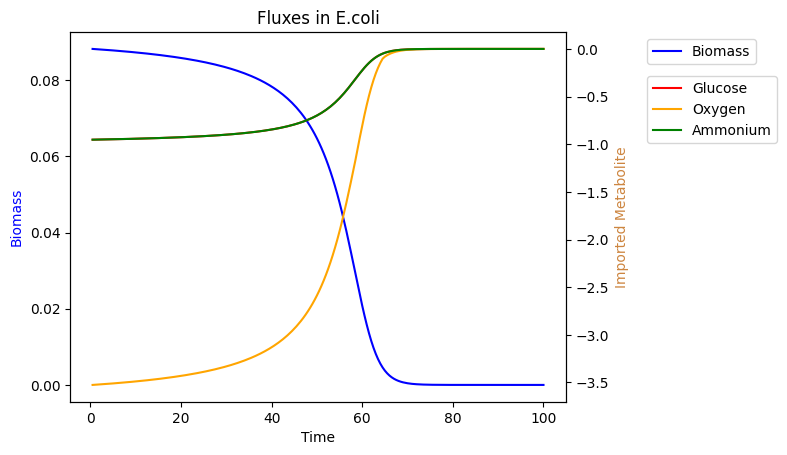

In [25]:
glucose = []
oxygen = []
ammonium = []
biomass = []

for i in fluxes_E:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["BIOMASS_Ec_iML1515_core_75p37M"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="blue", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="green", label="Ammonium")
ax.set_ylabel("Biomass", color="blue")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel("Time")

ax.set_title("Fluxes in E.coli")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

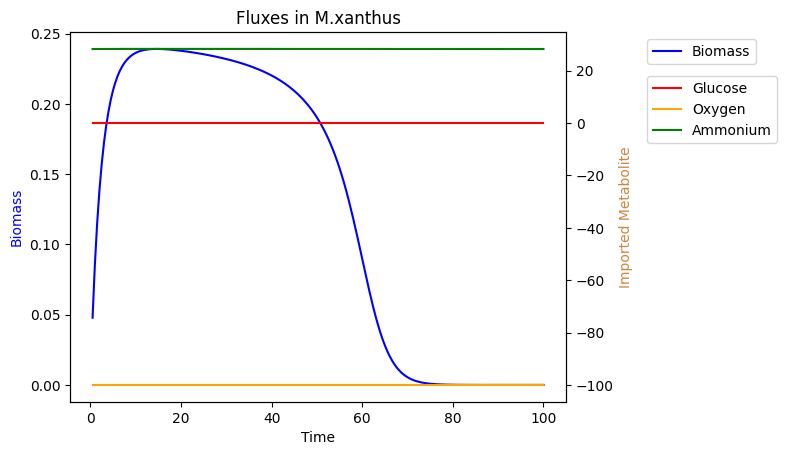

In [26]:
glucose = []
oxygen = []
ammonium = []
biomass = []

for i in fluxes_M:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["OF_BIOMASS"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="blue", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="green", label="Ammonium")

ax.set_ylabel("Biomass", color="blue")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel("Time")

ax.set_title("Fluxes in M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

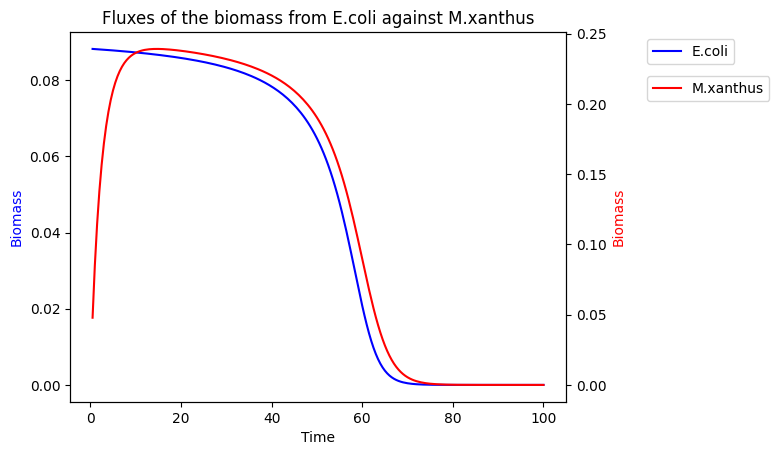

In [27]:
biomass_E = []
biomass_M = []

for i in fluxes_M:
    biomass_M.append(i["OF_BIOMASS"])  # taking the biomass flux
for j in fluxes_E:
    biomass_E.append(j["BIOMASS_Ec_iML1515_core_75p37M"])


ax = plt.subplot(111)
ax.plot(
    time_point[1:], biomass_E, color="blue", label="E.coli"
)  # plot the biomass flux of E_coli
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], biomass_M, color="red", label="M.xanthus")

ax.set_ylabel("Biomass", color="blue")  # set the name
ax2.set_ylabel("Biomass", color="red")
ax.set_xlabel("Time")

ax.set_title("Fluxes of the biomass from E.coli against M.xanthus")  # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

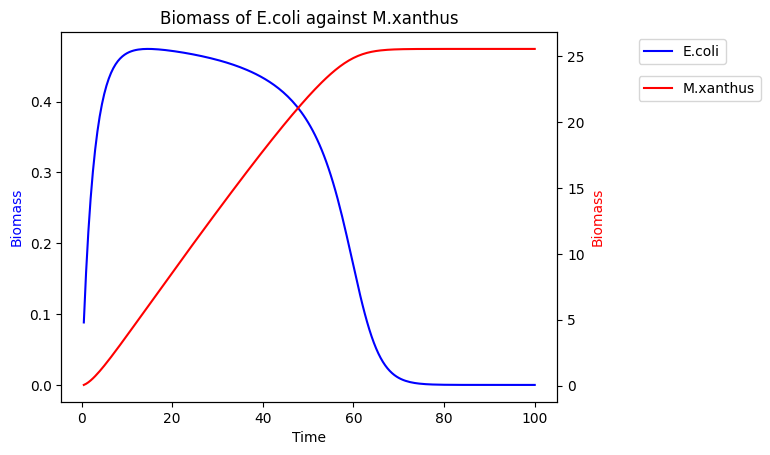

In [32]:
ax = plt.subplot(111)
ax.plot(
    time_point[1:], Biomass_E[1:], color="blue", label="E.coli"
)  # plot the biomass flux of E_coli
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], Biomass_M[1:], color="red", label="M.xanthus")

ax.set_ylabel("Biomass", color="blue")  # set the name
ax2.set_ylabel("Biomass", color="red")
ax.set_xlabel("Time")

ax.set_title("Biomass of E.coli against M.xanthus")  # set the title
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")  # show the legend
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")